# Project III: Did a Hockey Fan Write This?

## Problem Statement

After watching the US exit the World Cup, your American friends have decided to get into an argument at the cookout over what kind of sporting events they like to follow and why. Chief among their concerns is the question of which fandom is more annoying online - hockey fans or basketball fans. Naturally, each warring faction has decided to double down on the idea that it's actually the other fandom can stereotyped via their mannerisms, turns of phrase, and foolish notions of what makes for good sportsmanship.

You do not watch sports because you are a nerd and you like computers more, so you get a cheeky idea that is sure to annoy both sides. You tell them both fandoms are equally silly and simple-minded. Years from now, you will cringe at your use of the term "sportsball" and realize people don't talk to you at the water cooler because you're kind of tedious.

But today is not that day. You propose to write a computer program that takes training data in the form of Reddit forum posts corresponding to the NHL and the NBA, and you bet twenty dollars your computer program can correctly guess who wrote it - someone posting on r/NHL or someone posting on r/NBA. While your friends appreciate the awesome power of computers, they're not totally convinced that computers can process language in this specific way yet. What's your computer program going to do? Count words? Seems foolish.

## Cleaning Data

After wrestling with Reddit's PushShift API, you've managed to get ahold of a pair of .csv files corresponding to a set of forum posts from Reddit's r/NHL and r/NBA subreddits. Let's load these .csv files into Pandas and get to cleaning the data before it can be processed by our NLP models.

In [116]:
## Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

import re

from matplotlib_venn import venn2

We should be able to do roughly the same things to our NBA and NHL datasets in order to clean them. Let's load these datasets and compare them.

In [117]:
nba_df = pd.read_csv('../datasets/nba.csv')
nhl_df = pd.read_csv('../datasets/nhl.csv')

In [118]:
nba_df.shape, nhl_df.shape

((3000, 82), (3000, 86))

That's a little odd. What columns does NHL data that NBA data doesn't?

In [119]:
for column in nhl_df.columns:
    if column not in nba_df.columns:
        print(column)
    else:
        pass

gallery_data
is_gallery
media_metadata
poll_data


In [120]:
nba_df.columns # A list of all columns.

Index(['Unnamed: 0', 'all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id',
       'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked',
       'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'retrieved_on', 'score', 'selftext', 'send_replies',
       'spoiler', 'stickied', 'subr

We need to compare apples to apples. Columns that exist in one dataset but not in another are essentially useless. Let's drop those along with the Unnamed: 0 column.

In [121]:
nba_df.drop(columns = ['Unnamed: 0'], inplace=True)
nhl_df.drop(columns = ['Unnamed: 0', 'gallery_data', 'is_gallery', 'media_metadata', 'poll_data'], inplace=True)

There's still plenty of columns here. Recall that our basic plan is to take the text content of each post and run it through a model. Let's see where the text of a post lives.

In [122]:
for column in nba_df.columns:
    print(f"The following came from the column: {column}")
    print(nba_df[column][1])

The following came from the column: all_awardings
[]
The following came from the column: allow_live_comments
False
The following came from the column: author
talentpun
The following came from the column: author_flair_css_class
Raptors7
The following came from the column: author_flair_richtext
[{'e': 'text', 't': 'Raptors'}]
The following came from the column: author_flair_text
Raptors
The following came from the column: author_flair_type
richtext
The following came from the column: author_fullname
t2_lf95h
The following came from the column: author_is_blocked
False
The following came from the column: author_patreon_flair
False
The following came from the column: author_premium
False
The following came from the column: awarders
[]
The following came from the column: can_mod_post
False
The following came from the column: contest_mode
False
The following came from the column: created_utc
1629344849
The following came from the column: domain
streamable.com
The following came from the colum

It seems the body of a post lives in the column **selftext**. We might also be able to get a bit of info from the **title** of a post. Thing is, while pushshift can give us an awful lot of data about a particular post, we don't need all of it, nor should we keep data that will defeat the point of this exercise (which is identifying where a post came from based on what the post talks about). 

To see what I mean by this, we have a column, **full_link**, which gives us the link to the post itself. If I wanted to "predict" where a post came from, I'd need only reference this column, but that's not the point of our exercise. Let's list a few columns of just text that can give us info that isn't literally "this came from r/NBA."

Columns I'm likely going to care the most about:
- subreddit (will be our y variable later)
- title
- selftext

In [123]:
## Here's an example of some self_text content
nba_df[nba_df['selftext'].notna()]['selftext'][9]

'Offensively, Is James Harden better than peak kobe bryant? Defense is not factored in. \n\nThis debate is currently dividing some people on nba twitter. I personally take harden because of his efficiency and playmaking but people are saying kobe is better because of “floor raising” and “off ball movement”. Who do you think is the better offensive player at their respective peaks?'

We know from personal experience that sometimes people simply post titles and links in Reddit submissions. How often does that happen in the r/NBA subreddit, for example?

In [124]:
nba_df['selftext'].notna().sum(), nba_df['title'].notna().sum()

(1714, 3000)

_Nearly half_ of the posts in the NBA corpus have the **selftext** column empty. To some extent, this makes some sense: basketball fans seem to love posting, for example, YouTube clips of replays rather than putting text in the body of the post. However, if we want to process text, we can rest assured that at least all of these posts have titles. 

Let's take a quick look at the distribution of non-empty posts in each subreddit:

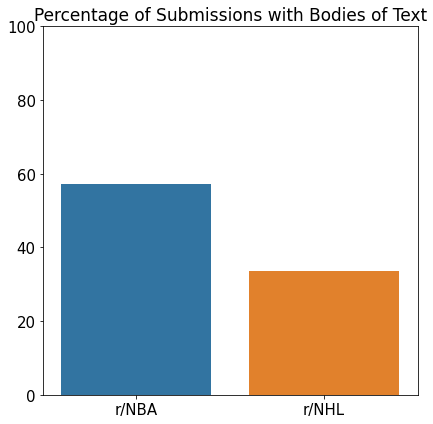

In [125]:
nba_posts_notempty = nba_df.notnull().sum()['selftext']/nba_df.shape[0]*100
nhl_posts_notempty = nhl_df.notnull().sum()['selftext']/nhl_df.shape[0]*100

plt.figure(figsize = (6,6))
sns.barplot(y = [nba_posts_notempty, nhl_posts_notempty], x = ['r/NBA','r/NHL'])
plt.title('Percentage of Submissions with Bodies of Text', fontsize=17)
plt.ylim(0,100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

This poses something of a problem - if only about 1/3 to 2/3 of the data represent submissions with actual bodies of text in them, the text we process for our NLP models will have a tendency to draw from the text in the title rather than the body of the submission.

In light of this, let's mold our future training data as best we can: Let's create a new column that takes the title and text of these posts and turns them into a single text document, with whatever string makes up the title leading the document. I'm thinking of something like the following:

In [126]:
nba_df[nba_df['selftext'].notna()]['title'][9] + " " + nba_df[nba_df['selftext'].notna()]['selftext'][9]

'Peak for Peak: Harden or Kobe offensively? Offensively, Is James Harden better than peak kobe bryant? Defense is not factored in. \n\nThis debate is currently dividing some people on nba twitter. I personally take harden because of his efficiency and playmaking but people are saying kobe is better because of “floor raising” and “off ball movement”. Who do you think is the better offensive player at their respective peaks?'

However, we're going to have to fill in those NaNs in selftext with **something** in order to create the title + selftext combination. Let's go with an empty string.

In [127]:
nba_df['selftext'].fillna("", inplace=True)
nhl_df['selftext'].fillna("", inplace=True)

In [128]:
nba_df['full_text'] = nba_df['title'] + " " + nba_df['selftext']
nhl_df['full_text'] = nhl_df['title'] + " " + nhl_df['selftext']

In [129]:
nba_df['full_text'].head(20)

0     OC: Rookies Adjusting To The NBA (easier for s...
1     One of the highest upvoted posts and greatest ...
2     2020 Lakers were up at least 30 points in each...
3     Chicago Bears Coach Matt Nagy Uses Giannis NBA...
4     Kevin Durant Takes Over In 2012 NBA Finals Gam...
5     Carmelo Anthony says Pistons 'promised' to pic...
6       when i say curry has moves this is what i mean 
7                            Watch Netflix for a Year! 
8     Warriors C Kevon Looney Gets Owned By Kid At H...
9     Peak for Peak: Harden or Kobe offensively? Off...
10                          MJ "swishes" the golf shot 
11       MJ doing basketball things on the golf course 
12    Clutch playoff numbers for Kobe/Curry/LeBron/W...
13    “It was a basketball decision, but i also didn...
14    Tyler Herro giving back to the city today in a...
15    Max kellerman is leaving first take What’re yo...
16     Report: Max Kellerman's Future At ESPN Revealed 
17         How 2 Get Hardwood 4 WNBA Players? [r

That's interesting. What's with these "removed" tags? Let's see how many selftext entries have them.

In [130]:
(nba_df['selftext'] == '[removed]').sum(), (nhl_df['selftext'] == '[removed]').sum()

(385, 32)

OK, so there's a larger proportion of submissions in r/NBA that have this "removed" tag in their selftext compared to r/NHL. Let's keep this REMOVED tag for now. It might inadvertently be a signal for r/NBA.

Given these two datasets have the same set of columns, let's put this all into the same Pandas DataFrame so we can clean the full_text data as best we can. 

In [131]:
both_df = pd.concat([nba_df, nhl_df], ignore_index=True)

In [132]:
both_df.columns
## All seems fine

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id',
       'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked',
       'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'retrieved_on', 'score', 'selftext', 'send_replies',
       'spoiler', 'stickied', 'subreddit', 'subre

In [133]:
both_df['subreddit'].unique()
## Nothing Weird Here, only Two Subreddits!

array(['nba', 'nhl'], dtype=object)

## Further Cleaning

So now we have the raw material for what we're going to be working with here - the full text of the data and the subreddits in question, it's time to fix **Weird Stuff in the Text**.

Let's draw up a list of things we could do to clean this data further before we build out our models.

Things We Want To Get Rid Of
- NewLine Characters
- Regular Expressions

Both of these add noise to our data and *might* get in the way of functions that process it. Let's strip the ones we can identify at the outset.

In [134]:
# Examples of NewLine Characters in the Text
both_df[both_df['selftext'].str.contains('\n')]['selftext']

0       [**Ra asked me**](https://mediumlights.substac...
2       #[Game 4 vs Portland](https://www.basketball-r...
9       Offensively, Is James Harden better than peak ...
12      Clutch moments: two minutes remaining, with no...
15      What’re your guy’s thoughts? Personally I will...
                              ...                        
5963    I used to be able to search PIMS game by game ...
5969    \n\n[View Poll](https://www.reddit.com/poll/ni...
5970    I’m not saying this as a biased Canucks fan (I...
5975    \n\n[View Poll](https://www.reddit.com/poll/ni...
5996    \n\n[View Poll](https://www.reddit.com/poll/nh...
Name: selftext, Length: 1355, dtype: object

Seems there's many newline characters here. Let's strip them out.

In [135]:
# Getting rid of NewLine Characters
both_df['selftext'] = both_df['selftext'].replace('\n','', regex=True)
both_df[['selftext']]

,selftext
0,[**Ra asked me**](https://mediumlights.substac...
1,
2,#[Game 4 vs Portland](https://www.basketball-r...
3,
4,
...,...
5995,I want to go to either game 4 or game 6 in Min...
5996,[View Poll](https://www.reddit.com/poll/nhjpn9)
5997,
5998,I’m currently watching my first NHL playoff se...


In [136]:
both_df['full_text'] = both_df['title'] + " " + both_df['selftext'] # Updating our full_text column.

### Some More Info

Maybe hockey fans are more verbose than basketball fans. Maybe they are very expressive and use lots of punctuation (e.g. "DID YOU SEE THAT GOAL??!!!") Let's create a variable called post_length that takes the length of the string, in characters, making up a given selftext post, no matter the type of charater being typed in. Maybe that'll be a useful predictor later on.

In [137]:
both_df['post_length'] = both_df['selftext'].str.len()

In [138]:
both_df[['selftext', 'post_length']]

,selftext,post_length
0,[**Ra asked me**](https://mediumlights.substac...,5944
1,,0
2,#[Game 4 vs Portland](https://www.basketball-r...,557
3,,0
4,,0
...,...,...
5995,I want to go to either game 4 or game 6 in Min...,136
5996,[View Poll](https://www.reddit.com/poll/nhjpn9),47
5997,,0
5998,I’m currently watching my first NHL playoff se...,457


Well, here's a new issue - there's whole URLs plugged into the text of these posts. Let's get those out of there and get more accurate post lengths.

In [139]:
# Getting rid of URLs in selftext.

both_df['selftext'] = both_df['selftext'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [140]:
both_df['post_length'] = both_df['selftext'].str.len() # Calculating post length again

## Scanning Common Phrases Using CountVectorizer

Let's run a count vectorizer and see if we can spot any problems, either in the Titles or in the Selftext. 

CountVectorizer takes a collection of text documents (in our case, a collection of rows with strings in them) and converts it to a matrix of token counts (here, our tokens are generally words and phrases).

By running CountVectorizer, we should be able to see what the most common phrases in each subreddit are. It will also allow us to see if there are any anomalies in the data that recur often enough to have to be cleaned. 

In [141]:
cvt = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))
# Setting n_gram range from 2 to 3 words because I suspect phrases will prove 
# better signals than individual words

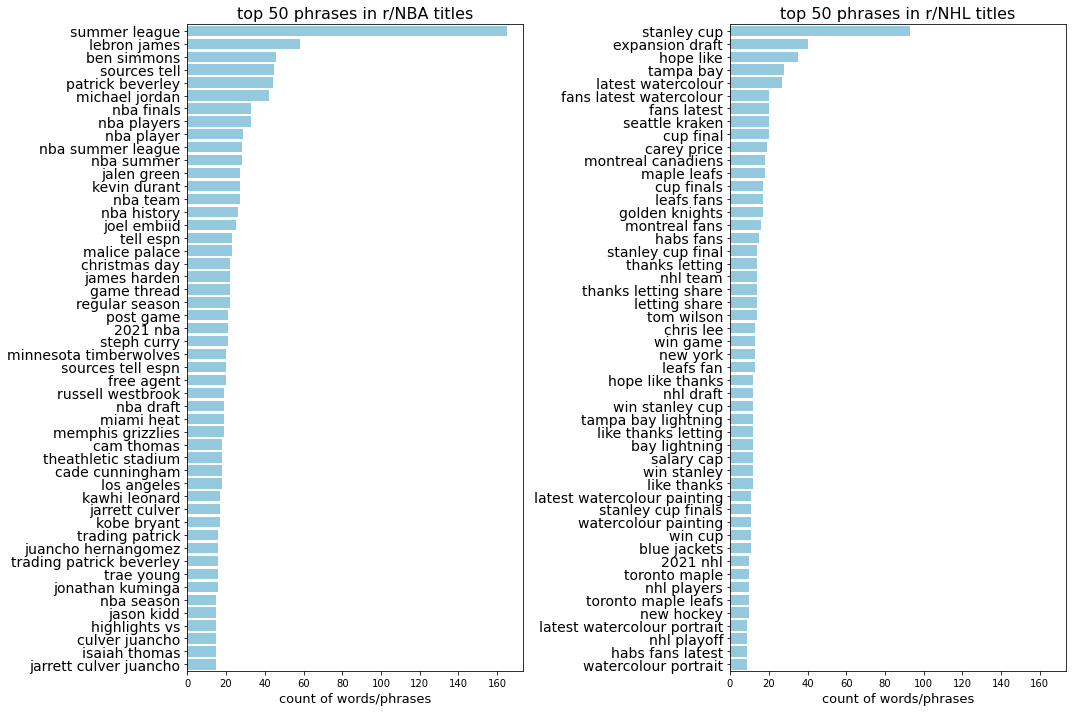

In [142]:
cvt = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

nhl_data = both_df[both_df['subreddit'] == 'nhl']
nba_data = both_df[both_df['subreddit'] == 'nba']

## r/NBA titles
cvt_nba = cvt.fit_transform(nba_data['title'])
cvt_nba_df = pd.DataFrame(cvt_nba.toarray(), columns = cvt.get_feature_names_out())
nba_top_50 = cvt_nba_df.sum().sort_values(ascending=False).head(50)

## r/NHL titles
cvt_nhl = cvt.fit_transform(nhl_data['title'])
cvt_nhl_df = pd.DataFrame(cvt_nhl.toarray(), columns = cvt.get_feature_names_out())
nhl_top_50 = cvt_nhl_df.sum().sort_values(ascending=False).head(50)

# Plotting the results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=nba_top_50.index.values, x = nba_top_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 phrases in r/NBA titles',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=nhl_top_50.index.values, x = nhl_top_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 phrases in r/NHL titles',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()


There's a handful of weird phrases here such as "hope like" and "latest watercolour painting" but a lot of this stuff does seem to be sports-league-specific! Looks good so far...

Now let's do the selftext contents of each submission. What are the most common phrases in there?

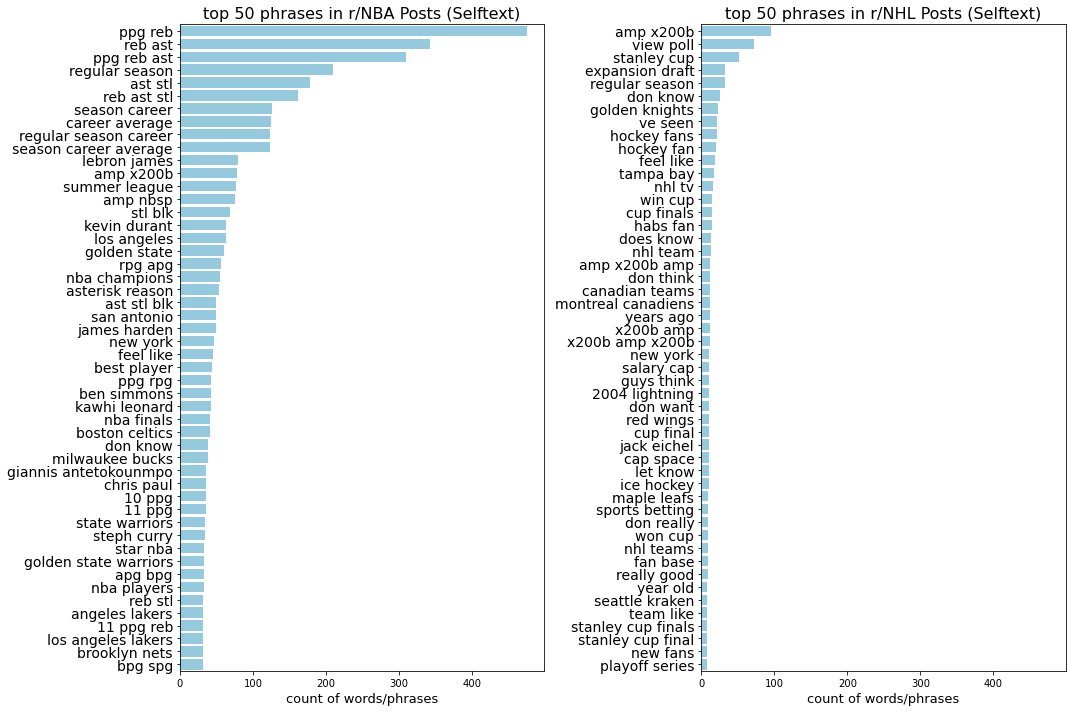

In [143]:
## r/NBA Selftexts
cvt_nba = cvt.fit_transform(nba_data['selftext'])
cvt_nba_df = pd.DataFrame(cvt_nba.toarray(), columns = cvt.get_feature_names_out())
nba_top_50 = cvt_nba_df.sum().sort_values(ascending=False).head(50)

## r/NHL Selftexts
cvt_nhl = cvt.fit_transform(nhl_data['selftext'])
cvt_nhl_df = pd.DataFrame(cvt_nhl.toarray(), columns = cvt.get_feature_names_out())
nhl_top_50 = cvt_nhl_df.sum().sort_values(ascending=False).head(50)

# Plotting the results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=nba_top_50.index.values, x = nba_top_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 phrases in r/NBA Posts (Selftext)',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=nhl_top_50.index.values, x = nhl_top_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 phrases in r/NHL Posts (Selftext)',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

There's a bit more noise in these phrases extracted from the selftext data.

The first suspects were those phrases in r/NBA such as "ppg reb" and "reb ast" but these are just abbreviations of basketball metrics: points-per-game, rebounds, assists, and the like. While they might look odd, they're still NBA-specific "words" and should be kept.

It's a different set of abbreviations that I think should be removed. 
- amp x200b
- amp nbsp
- amp x200b amp
- x200b

These seem to be character codes for zero-width spaces. The kind of thing that gets left behind after someone presses Return or the space bar a bunch of times when they write their post. This is noise and we should remove it.

We should also remove:
- View Poll

These are just the generic leftovers of posts that don't contain any actual bodies of text in them, just links to polls.

In [144]:
## Getting rid of a handful of regular expressions

both_df['selftext'].replace("&amp;", "", regex=True, inplace=True)
both_df['selftext'].replace("#x200B;", "", regex=True, inplace=True)
both_df['selftext'].replace("nbsp;", "", regex=True, inplace=True)

## Getting rid of "View Poll" posts.
both_df['selftext'].replace("View Poll", "", regex=True, inplace=True)

Now let's try checking these selftext phrases again:

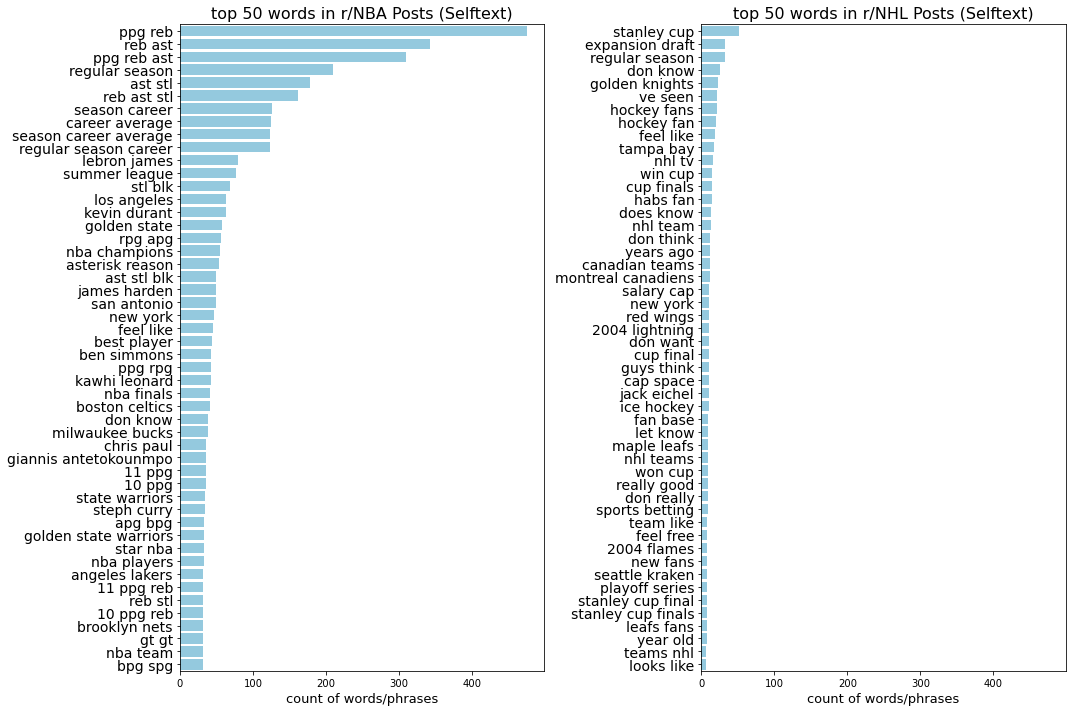

In [145]:
cvt = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

nhl_data = both_df[both_df['subreddit'] == 'nhl']
nba_data = both_df[both_df['subreddit'] == 'nba']

## r/NBA Selftexts
cvt_nba = cvt.fit_transform(nba_data['selftext'])
cvt_nba_df = pd.DataFrame(cvt_nba.toarray(), columns = cvt.get_feature_names_out())
nba_top_50 = cvt_nba_df.sum().sort_values(ascending=False).head(50)

## r/NHL Selftexts
cvt_nhl = cvt.fit_transform(nhl_data['selftext'])
cvt_nhl_df = pd.DataFrame(cvt_nhl.toarray(), columns = cvt.get_feature_names_out())
nhl_top_50 = cvt_nhl_df.sum().sort_values(ascending=False).head(50)

# Plotting the results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=nba_top_50.index.values, x = nba_top_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/NBA Posts (Selftext)',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=nhl_top_50.index.values, x = nhl_top_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/NHL Posts (Selftext)',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

Seems OK, but one thing we should point out here is that some terms dominate r/NBA posts to a much higher degree that **any** given phrase dominates the selftexts of r/NHL posts save for obvious terms like "stanley cup." Our NLP modeling might have to lean heavily on whatever text we see in submission titles.

Let's see if we get different results if we run a TfidVectorizer instead of a CountVectorizer.

## Scanning Common Phrases Using TfidVectorizer

TfidVectorizer is similar to CountVectorizer, with a few extra steps...

Where CountVectorizer produces a matrix containing the raw frequencies of words and phrases in a given corpus of documents, TfidVectorizer produces a value between 0 and 1 for each word or phrase being vectorized (0 for very uninformative vs 1 for very informative). This value is known as the TF-IDF of a given feature (TF for Term Frequency, IDF for Inverse Document Frequency).

TfidVectorizer calculates TF-IDF by calculating both **term frequency** (the  number of times a word appears in a document) as well as **document frequency** (the percentage of documents that a particular word appears in) and leverages these measurements to scale down the impact of terms that occur very frequently in a given corpus (and are thus less informative than features that occur in a small fraction of the training corpus). TF-IDF can thus be thought of as a measure of originality of a term.

Running TfidVectorizer may yield a set of features that may serve as stronger signals in a future model compared to those that CountVectorizer yields.

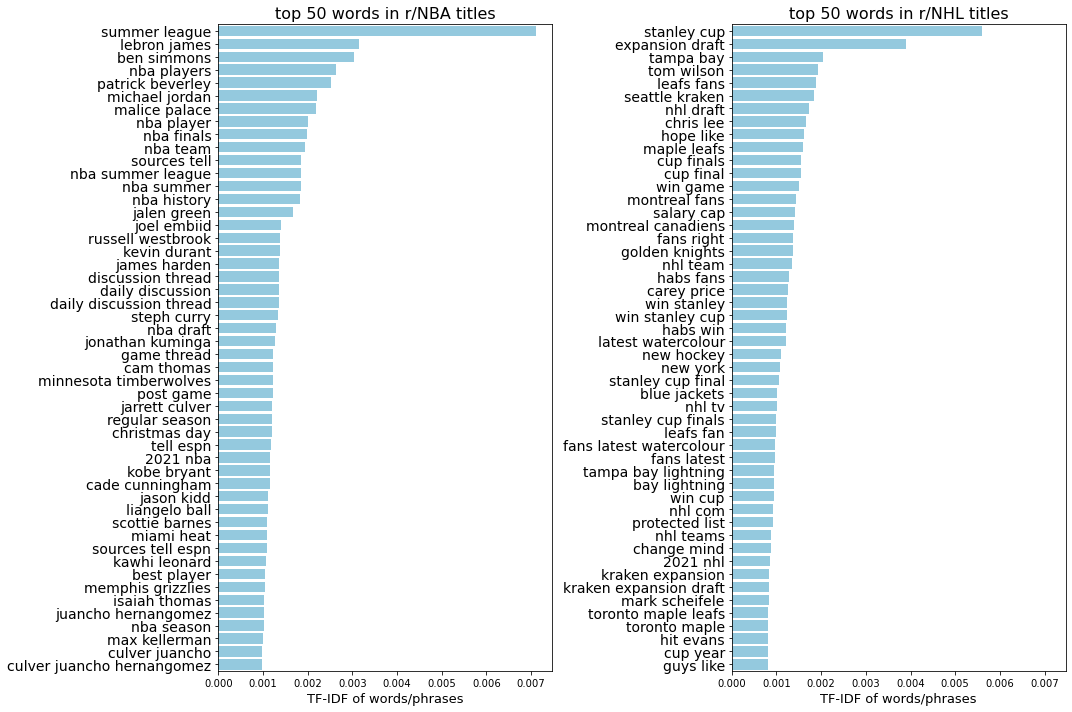

In [146]:
## Running TfidVectorizer on Title data

tfv = TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

nhl_data = both_df[both_df['subreddit'] == 'nhl']
nba_data = both_df[both_df['subreddit'] == 'nba']

## r/NBA titles
tfv_nba = tfv.fit_transform(nba_data['title'])
tfv_nba_df = pd.DataFrame(tfv_nba.toarray(), columns = tfv.get_feature_names_out())
nba_top_50 = tfv_nba_df.mean().sort_values(ascending=False).head(50)

## r/NHL titles
tfv_nhl = tfv.fit_transform(nhl_data['title'])
tfv_nhl_df = pd.DataFrame(tfv_nhl.toarray(), columns = tfv.get_feature_names_out())
nhl_top_50 = tfv_nhl_df.mean().sort_values(ascending=False).head(50)

# Plotting the results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=nba_top_50.index.values, x = nba_top_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/NBA titles',fontsize=16)
ax[0].set_xlabel('TF-IDF of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=nhl_top_50.index.values, x = nhl_top_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/NHL titles',fontsize=16)
ax[1].set_xlabel('TF-IDF of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

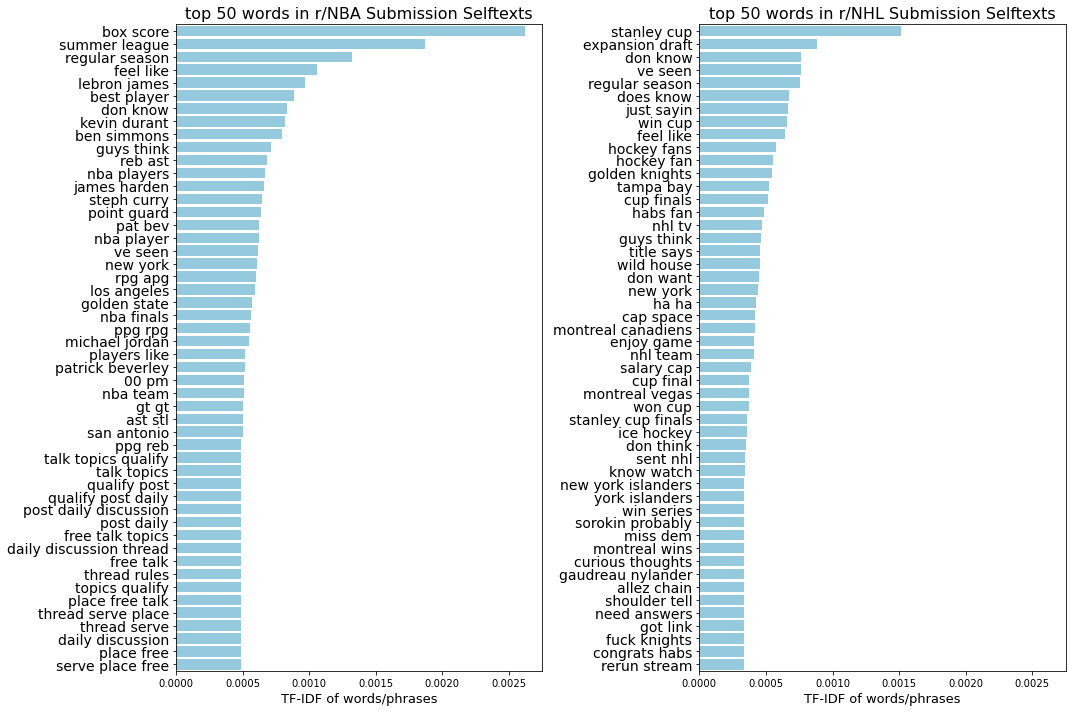

In [147]:
## Running TfidVectorizer on Selftext data

tfv = TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

nhl_data = both_df[both_df['subreddit'] == 'nhl']
nba_data = both_df[both_df['subreddit'] == 'nba']

## r/NBA titles
tfv_nba = tfv.fit_transform(nba_data['selftext'])
tfv_nba_df = pd.DataFrame(tfv_nba.toarray(), columns = tfv.get_feature_names_out())
nba_top_50 = tfv_nba_df.mean().sort_values(ascending=False).head(50)

## r/NHL titles
tfv_nhl = tfv.fit_transform(nhl_data['selftext'])
tfv_nhl_df = pd.DataFrame(tfv_nhl.toarray(), columns = tfv.get_feature_names_out())
nhl_top_50 = tfv_nhl_df.mean().sort_values(ascending=False).head(50)

# Plotting the results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=nba_top_50.index.values, x = nba_top_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/NBA Submission Selftexts',fontsize=16)
ax[0].set_xlabel('TF-IDF of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=nhl_top_50.index.values, x = nhl_top_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/NHL Submission Selftexts',fontsize=16)
ax[1].set_xlabel('TF-IDF of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

We see a lot of the same sets of phrases get thrown around, but notice how metrics abbreviations become less dominant in the r/NBA data - it seems those metrics might've been repeated a ton but weren't terribly informative. The set of potential signals seems as robust in r/NHL as in r/NBA. Note that no individual phrase has a TF-IDF that's even close to 1 - our model might have to leverage a large set of these to come up with good prediction.

## Am I Posting Too Much?

Now let's take a look at distributions of title lengths and post lengths. Perhaps different varieties of sports posters are more verbose!

Earlier we defined post_length as the amount of characters in a given selftext string. This time around we'll want a measure that's a bit clearer. Let's count the number of words instead of characters in our submission titles and selftext.

In [148]:
## Counting words in Title and Selftext
both_df["title_length"] = [len(x) for x in both_df['title'].str.split(" ")]
both_df["selftext_length"] = [len(x) for x in both_df['selftext'].str.split(" ")]

In [149]:
both_df[['title', 'title_length']].head(10)

,title,title_length
0,OC: Rookies Adjusting To The NBA (easier for s...,12
1,One of the highest upvoted posts and greatest ...,19
2,2020 Lakers were up at least 30 points in each...,13
3,Chicago Bears Coach Matt Nagy Uses Giannis NBA...,14
4,Kevin Durant Takes Over In 2012 NBA Finals Gam...,18
5,Carmelo Anthony says Pistons 'promised' to pic...,16
6,when i say curry has moves this is what i mean,11
7,Watch Netflix for a Year!,5
8,Warriors C Kevon Looney Gets Owned By Kid At H...,12
9,Peak for Peak: Harden or Kobe offensively?,7


In [150]:
both_df[['selftext', 'selftext_length', 'post_length']].head(10)

,selftext,selftext_length,post_length
0,[**Ra asked me**]( Was Anthony Edwards' rookie...,1009,5864
1,,1,0
2,#[Game 4 vs Portland]( - Largest lead 38 point...,39,212
3,,1,0
4,,1,0
5,,1,0
6,,1,0
7,,1,0
8,,1,0
9,"Offensively, Is James Harden better than peak ...",62,378


It seems that our attempt to count words falls apart when the selftext itself is empty. Let's leverage our post_length column to correct for this quirk.

In [151]:
both_df.loc[ both_df['post_length'] == 0, "selftext_length"] = 0

In [152]:
both_df[['selftext', 'selftext_length', 'post_length']].head(10)

,selftext,selftext_length,post_length
0,[**Ra asked me**]( Was Anthony Edwards' rookie...,1009,5864
1,,0,0
2,#[Game 4 vs Portland]( - Largest lead 38 point...,39,212
3,,0,0
4,,0,0
5,,0,0
6,,0,0
7,,0,0
8,,0,0
9,"Offensively, Is James Harden better than peak ...",62,378


There we go!

In [153]:
both_df[both_df['selftext_length'] == 1][['title', 'selftext', 'selftext_length', 'post_length']].head(10)

,title,selftext,selftext_length,post_length
13,"“It was a basketball decision, but i also didn...",[removed],1,9
17,How 2 Get Hardwood 4 WNBA Players?,[removed],1,9
19,clothes recommendations,[removed],1,9
21,How 2 Get Hard Wood 4 WNBA Players?,[removed],1,9
22,The Best Athlete in a Los Angeles Team Current...,[removed],1,9
31,The upvotes on your top post of all-time is th...,[removed],1,9
35,"In 2004, the Utah Jazz were fined $15,000 for ...",[removed],1,9
46,Hot Take: Tim Duncan is my pick for best all-t...,[removed],1,9
75,Why does this sub hate the NFL so much?,[removed],1,9
76,Does Andre Drummond make the 76ers instant tit...,[removed],1,9


Despite these submissions with 1 word are just posts whose selftext was actualy removed, these submissions to have titles, so we won't strike them. Now let's look at the distribution of title length and selftext length (in words).

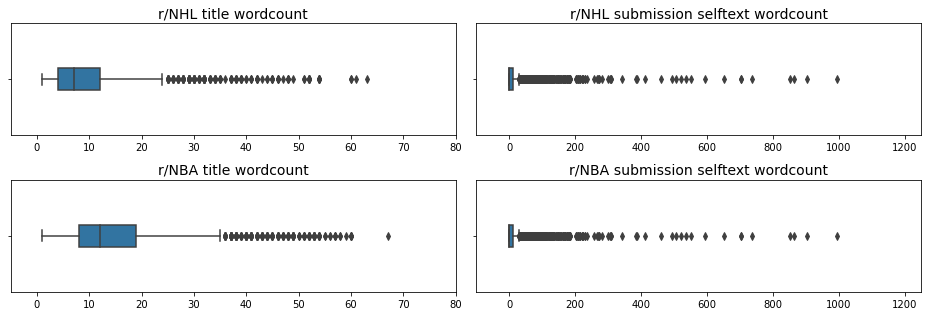

In [154]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (13, 4.5))

nhl_data = both_df[both_df['subreddit'] == 'nhl']
nba_data = both_df[both_df['subreddit'] == 'nba']

# NHL Word Count Plots
sns.boxplot(x = nhl_data['title_length'], ax = ax[0][0], width = 0.2)
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,80)
ax[0][0].set_title('r/NHL title wordcount', fontsize=14)

sns.boxplot(x = nhl_data['selftext_length'], ax = ax[0][1], width = 0.2)
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,1250)
ax[0][1].set_title('r/NHL submission selftext wordcount', fontsize=14)

# NBA Word Count Plots
sns.boxplot(x = nba_data['title_length'], ax = ax[1][0], width = 0.2)
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,80)
ax[1][0].set_title('r/NBA title wordcount', fontsize=14)

sns.boxplot(x = nhl_data['selftext_length'], ax = ax[1][1], width = 0.2)
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,1250)
ax[1][1].set_title('r/NBA submission selftext wordcount', fontsize=14)

plt.tight_layout();

When it comes to submission selftexts, there's an abundance of emptiness. When it comes to submission **titles** however, these are usually between 5-20 words or so. r/NBA submission titles are marginally longer on average. Let's look at the outliers and see if we find anything super strange.

In [155]:
nhl_data[nhl_data['title_length'] > 25]['title']
#Only a handful of these, but do we have a reason to strike?

3006    [JameyBaskow] Newly signed Flyers prospect Sam...
3008    [Wyshynski] Aleksander Barkov is entering the ...
3010    [Pierce] Zach Parise said a few days after the...
3011    Prose and Kohn: From the Lakewood Ranch area t...
3013    [Johnston] The Maple Leafs and Raptors will re...
                              ...                        
5952    Thеre is a Youtuber callеd "Leоn Farаdаy" that...
5956    It’s sad that Laffs fans still can’t grasp tha...
5965    Why is the schedule so disjointed this year (I...
5972    NBC IS RIDICULOUS FOR NOT SHOWING THE AVS. INS...
5992    There is a Youtubеr саllеd "Lеon Fаrаday" thаt...
Name: title, Length: 165, dtype: object

In [156]:
nhl_data[nhl_data['title_length'] > 25]['title'][5956]

'It’s sad that Laffs fans still can’t grasp that despite Perry’s reputation, what happened on Thursday night was a freak accident. Perry and Foligno settled it immediately, no excuse for wishing ill on Price. Laffs fans are pathetic.'

So it seems NHL title length outliers include folks just really getting into their feelings. Odd, but we'll let it pass. After all, these titles are basically selftext in practical terms - the body of the submission is all in the title.

In [157]:
nba_data[nba_data['title_length'] > 35]['title']

49      The Blazers are absolutely elite at getting ro...
68      Dennis Schroder finished in the top 10 in midr...
92      Lance Stephenson is often considered a jester ...
112     How did the Rockets and specifically James Har...
133     Davion Mitchell: "I’ve kind of always been lik...
                              ...                        
2941    Damian Lillard is not currently available for ...
2949    The Clippers told Kobe he had given them the b...
2957    [Joe Ingles] shares a wholesome dad moment: "M...
2986    [Andrews] Nets GM Sean Marks said that the Net...
2998    [Discussion] Is elite passing ability/vision/d...
Name: title, Length: 208, dtype: object

In [158]:
nba_data[nba_data['title_length'] > 35]['title'][2941]

'Damian Lillard is not currently available for a trade and he has also not requested one from the Portland Trail Blazers, sources tell Zach Lowe of ESPN. A trade of Lillard, if it does happen during the 21-22 season, is widely expected to come down to the Philadelphia 76ers and New York Knicks.'

In this instance, this title could, in another life, have been the body of a submission's selftext. We should keep these as well.

Given I do not expect to present boxplots, let's get this same information in the form of histograms.

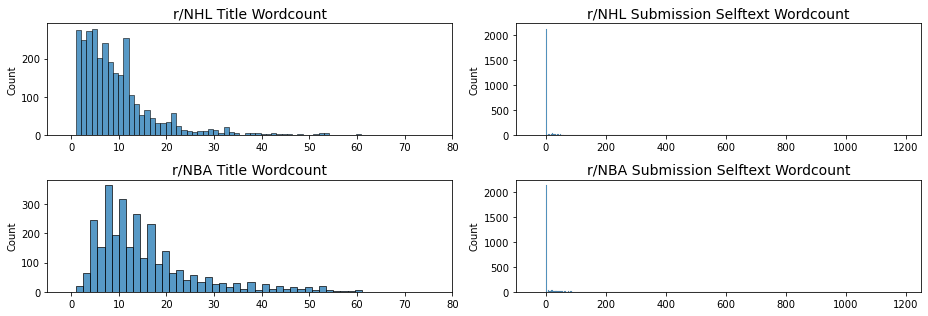

In [159]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (13, 4.5))

nhl_data = both_df[both_df['subreddit'] == 'nhl']
nba_data = both_df[both_df['subreddit'] == 'nba']

# NHL Word Count Plots
sns.histplot(x = nhl_data['title_length'], ax = ax[0][0])
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,80)
ax[0][0].set_title('r/NHL Title Wordcount', fontsize=14)

sns.histplot(x = nhl_data['selftext_length'], ax = ax[0][1])
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,1250)
ax[0][1].set_title('r/NHL Submission Selftext Wordcount', fontsize=14)

# NBA Word Count Plots
sns.histplot(x = nba_data['title_length'], ax = ax[1][0])
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,80)
ax[1][0].set_title('r/NBA Title Wordcount', fontsize=14)

sns.histplot(x = nhl_data['selftext_length'], ax = ax[1][1])
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,1250)
ax[1][1].set_title('r/NBA Submission Selftext Wordcount', fontsize=14)

plt.tight_layout();

This is just a re-visualization of the same data. The selftext wordcounts visuals are dismal, so maybe we'll leave those out of our presentation.

## Do the Subreddits Share Phrases?

Let's see if the words contained in the titles and submission selftexts are similar across both subreddits.



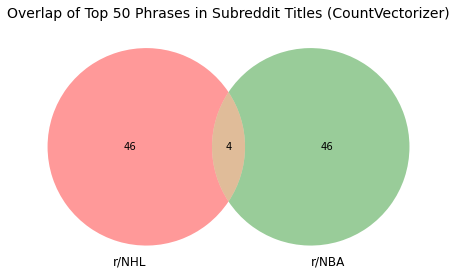

In [160]:
## Running CountVectorizer on Title data

cvt = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

nhl_data = both_df[both_df['subreddit'] == 'nhl']
nba_data = both_df[both_df['subreddit'] == 'nba']

## r/NBA Selftexts
cvt_nba = cvt.fit_transform(nba_data['selftext'])
cvt_nba_df = pd.DataFrame(cvt_nba.toarray(), columns = cvt.get_feature_names_out())
nba_top_50 = cvt_nba_df.sum().sort_values(ascending=False).head(50)

## r/NHL Selftexts
cvt_nhl = cvt.fit_transform(nhl_data['selftext'])
cvt_nhl_df = pd.DataFrame(cvt_nhl.toarray(), columns = cvt.get_feature_names_out())
nhl_top_50 = cvt_nhl_df.sum().sort_values(ascending=False).head(50)


venn2([set(nhl_top_50.index), set(nba_top_50.index)], set_labels = ('r/NHL','r/NBA'))
plt.title('Overlap of Top 50 Phrases in Subreddit Titles (CountVectorizer)', fontsize=14)
plt.tight_layout()

What might these words in common be?

In [161]:
for word in nhl_top_50.index:
    if word in nba_top_50.index:
        print(word)
    else:
        pass

regular season
don know
feel like
new york


How about with TfidVectorizer?

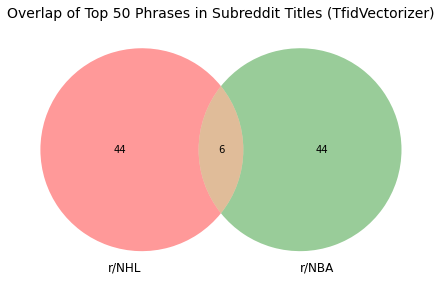

In [162]:
tfv = TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

nhl_data = both_df[both_df['subreddit'] == 'nhl']
nba_data = both_df[both_df['subreddit'] == 'nba']

## r/NBA titles
tfv_nba = tfv.fit_transform(nba_data['selftext'])
tfv_nba_df = pd.DataFrame(tfv_nba.toarray(), columns = tfv.get_feature_names_out())
nba_top_50 = tfv_nba_df.mean().sort_values(ascending=False).head(50)

## r/NHL titles
tfv_nhl = tfv.fit_transform(nhl_data['selftext'])
tfv_nhl_df = pd.DataFrame(tfv_nhl.toarray(), columns = tfv.get_feature_names_out())
nhl_top_50 = tfv_nhl_df.mean().sort_values(ascending=False).head(50)

venn2([set(nhl_top_50.index), set(nba_top_50.index)], set_labels = ('r/NHL','r/NBA'))
plt.title('Overlap of Top 50 Phrases in Subreddit Titles (TfidVectorizer)', fontsize=14)
plt.tight_layout()

In [163]:
for word in nhl_top_50.index:
    if word in nba_top_50.index:
        print(word)
    else:
        pass

don know
ve seen
regular season
feel like
guys think
new york


Looks like people in either sport don't know things, have seen things, are often feeling things, and talk about New York an awful lot. Sounds about right.

When we get to modeling, these might be sort of terms I'm going to want to drop if our initial set of models do poorly. They're high up there in our counts for each vectorizer, but they're so generic they likely won't help us classify a submission.

Time to get to modeling.